In [1]:
%%capture
!pip install super-gradients

from PIL import Image
import os
import numpy as np
import torch

import random
import pathlib

from torch.utils.data import Dataset
import json
from torchvision import transforms, utils


import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt


import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class config:
    #trainer params
    CHECKPOINT_DIR = '/content/drive/MyDrive/PCD/object-detection/checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'fruit-detector' #specify the experiment name

    #dataset params
    DATA_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection' #parent directory to where data lives

    TRAIN_IMAGES_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/valid/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = '/content/drive/MyDrive/PCD/object-detection/Fruit Detection Dataset/Fruits-detection/test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

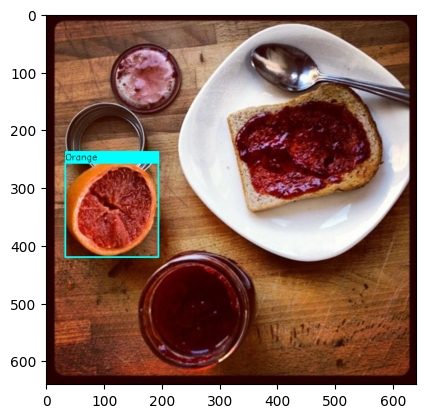

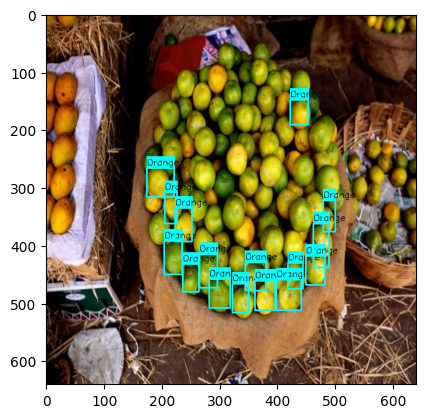

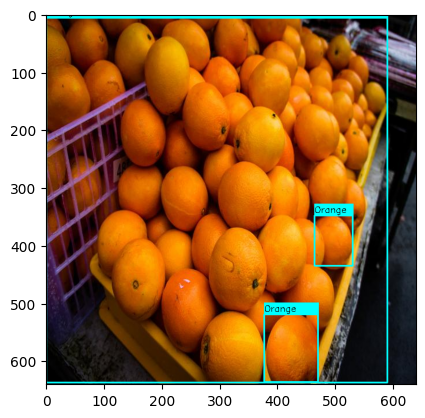

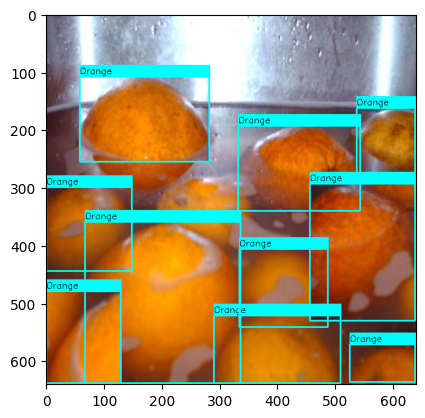

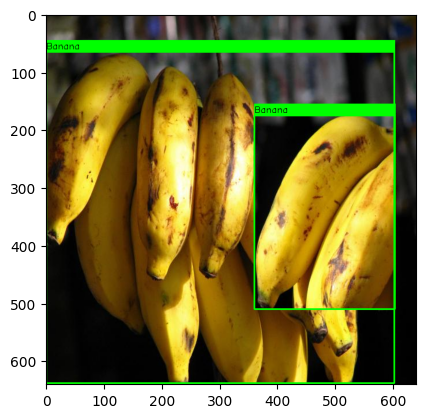

In [4]:
train_images_dir= os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR)
train_labels_dir= os.path.join(config.DATA_DIR, config.TRAIN_LABELS_DIR)
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(train_images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files

selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(train_labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = config.CLASSES

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [5]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Indexing dataset annotations: 100%|██████████| 457/457 [01:45<00:00,  4.32it/s]


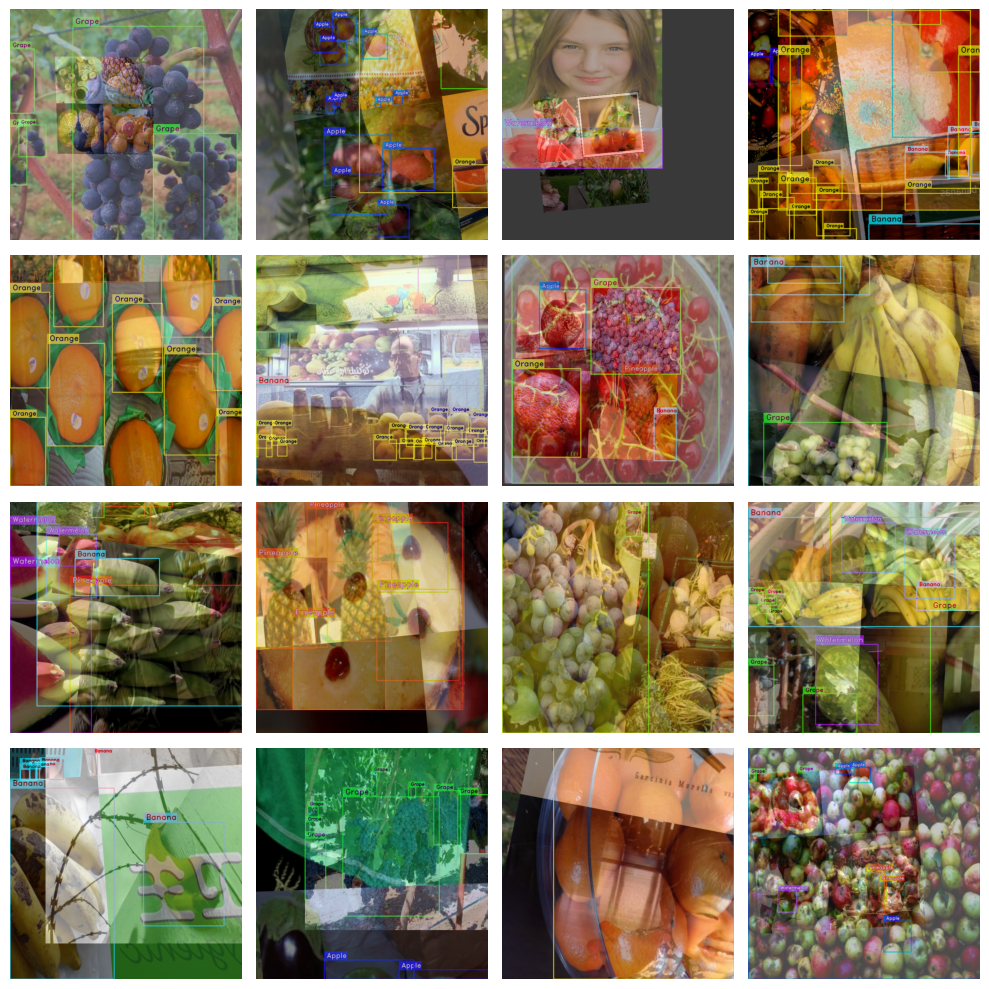

In [7]:
train_data.dataset.plot()

In [8]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:02<00:00, 91.8MB/s]


In [9]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "lr_warmup_epochs": 5,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [10]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-06-12 11:06:57] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incom

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6817
│   ├── Ppyoloeloss/loss_iou = 0.5159
│   ├── Ppyoloeloss/loss_dfl = 0.6109
│   └── Ppyoloeloss/loss = 2.8086
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3358
    ├── Ppyoloeloss/loss_iou = 0.4382
    ├── Ppyoloeloss/loss_dfl = 0.5643
    ├── Ppyoloeloss/loss = 2.3382
    ├── Precision@0.50 = 0.0407
    ├── Recall@0.50 = 0.6497
    ├── Map@0.50 = 0.2437
    ├── F1@0.50 = 0.0764
    └── Best_score_threshold = 0.33



Validating epoch 1: 100%|██████████| 57/57 [00:10<00:00,  5.29it/s]
[2024-06-12 11:18:56] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 11:18:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.31352952122688293


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2054
│   │   ├── Epoch N-1      = 1.6817 (↘ -0.4763)
│   │   └── Best until now = 1.6817 (↘ -0.4763)
│   ├── Ppyoloeloss/loss_iou = 0.4659
│   │   ├── Epoch N-1      = 0.5159 (↘ -0.0501)
│   │   └── Best until now = 0.5159 (↘ -0.0501)
│   ├── Ppyoloeloss/loss_dfl = 0.5527
│   │   ├── Epoch N-1      = 0.6109 (↘ -0.0582)
│   │   └── Best until now = 0.6109 (↘ -0.0582)
│   └── Ppyoloeloss/loss = 2.224
│       ├── Epoch N-1      = 2.8086 (↘ -0.5846)
│       └── Best until now = 2.8086 (↘ -0.5846)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2648
    │   ├── Epoch N-1      = 1.3358 (↘ -0.071)
    │   └── Best until now = 1.3358 (↘ -0.071)
    ├── Ppyoloeloss/loss_iou = 0.43
    │   ├── Epoch N-1      = 0.4382 (↘ -0.0082)
    │   └── Best until now = 0.4382 (↘ -0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.563
    │   ├── Epoch N-1      = 0.5643 (↘ -0.0013)
    │   └── Best until now = 0.5643 (↘ -0.0013)
    ├── Ppyoloeloss/loss = 2

Validating epoch 2: 100%|██████████| 57/57 [00:10<00:00,  5.38it/s]
[2024-06-12 11:24:49] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 11:24:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.33966395258903503


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1523
│   │   ├── Epoch N-1      = 1.2054 (↘ -0.0531)
│   │   └── Best until now = 1.2054 (↘ -0.0531)
│   ├── Ppyoloeloss/loss_iou = 0.442
│   │   ├── Epoch N-1      = 0.4659 (↘ -0.0238)
│   │   └── Best until now = 0.4659 (↘ -0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.5416
│   │   ├── Epoch N-1      = 0.5527 (↘ -0.0111)
│   │   └── Best until now = 0.5527 (↘ -0.0111)
│   └── Ppyoloeloss/loss = 2.1359
│       ├── Epoch N-1      = 2.224  (↘ -0.088)
│       └── Best until now = 2.224  (↘ -0.088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2119
    │   ├── Epoch N-1      = 1.2648 (↘ -0.0529)
    │   └── Best until now = 1.2648 (↘ -0.0529)
    ├── Ppyoloeloss/loss_iou = 0.4638
    │   ├── Epoch N-1      = 0.43   (↗ 0.0338)
    │   └── Best until now = 0.43   (↗ 0.0338)
    ├── Ppyoloeloss/loss_dfl = 0.5857
    │   ├── Epoch N-1      = 0.563  (↗ 0.0227)
    │   └── Best until now = 0.563  (↗ 0.0227)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 3: 100%|██████████| 57/57 [00:10<00:00,  5.39it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1317
│   │   ├── Epoch N-1      = 1.1523 (↘ -0.0206)
│   │   └── Best until now = 1.1523 (↘ -0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.4386
│   │   ├── Epoch N-1      = 0.442  (↘ -0.0034)
│   │   └── Best until now = 0.442  (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.5362
│   │   ├── Epoch N-1      = 0.5416 (↘ -0.0054)
│   │   └── Best until now = 0.5416 (↘ -0.0054)
│   └── Ppyoloeloss/loss = 2.1065
│       ├── Epoch N-1      = 2.1359 (↘ -0.0294)
│       └── Best until now = 2.1359 (↘ -0.0294)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2612
    │   ├── Epoch N-1      = 1.2119 (↗ 0.0493)
    │   └── Best until now = 1.2119 (↗ 0.0493)
    ├── Ppyoloeloss/loss_iou = 0.4669
    │   ├── Epoch N-1      = 0.4638 (↗ 0.0031)
    │   └── Best until now = 0.43   (↗ 0.0369)
    ├── Ppyoloeloss/loss_dfl = 0.5871
    │   ├── Epoch N-1      = 0.5857 (↗ 0.0014)
    │   └── Best until now = 0.563  (↗ 0.0241)
    ├── Ppyoloeloss/loss = 2

Validating epoch 4: 100%|██████████| 57/57 [00:10<00:00,  5.32it/s]
[2024-06-12 11:36:34] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 11:36:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3459843099117279


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1291
│   │   ├── Epoch N-1      = 1.1317 (↘ -0.0025)
│   │   └── Best until now = 1.1317 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.438
│   │   ├── Epoch N-1      = 0.4386 (↘ -0.0006)
│   │   └── Best until now = 0.4386 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5401
│   │   ├── Epoch N-1      = 0.5362 (↗ 0.0039)
│   │   └── Best until now = 0.5362 (↗ 0.0039)
│   └── Ppyoloeloss/loss = 2.1072
│       ├── Epoch N-1      = 2.1065 (↗ 0.0007)
│       └── Best until now = 2.1065 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2098
    │   ├── Epoch N-1      = 1.2612 (↘ -0.0513)
    │   └── Best until now = 1.2119 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.4616
    │   ├── Epoch N-1      = 0.4669 (↘ -0.0053)
    │   └── Best until now = 0.43   (↗ 0.0316)
    ├── Ppyoloeloss/loss_dfl = 0.5904
    │   ├── Epoch N-1      = 0.5871 (↗ 0.0033)
    │   └── Best until now = 0.563  (↗ 0.0273)
    ├── Ppyoloeloss/loss = 2.2

Validating epoch 5: 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1231
│   │   ├── Epoch N-1      = 1.1291 (↘ -0.0061)
│   │   └── Best until now = 1.1291 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.4388
│   │   ├── Epoch N-1      = 0.438  (↗ 0.0008)
│   │   └── Best until now = 0.438  (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.543
│   │   ├── Epoch N-1      = 0.5401 (↗ 0.0029)
│   │   └── Best until now = 0.5362 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 2.1049
│       ├── Epoch N-1      = 2.1072 (↘ -0.0024)
│       └── Best until now = 2.1065 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.328
    │   ├── Epoch N-1      = 1.2098 (↗ 0.1182)
    │   └── Best until now = 1.2098 (↗ 0.1182)
    ├── Ppyoloeloss/loss_iou = 0.4807
    │   ├── Epoch N-1      = 0.4616 (↗ 0.0191)
    │   └── Best until now = 0.43   (↗ 0.0507)
    ├── Ppyoloeloss/loss_dfl = 0.6117
    │   ├── Epoch N-1      = 0.5904 (↗ 0.0214)
    │   └── Best until now = 0.563  (↗ 0.0487)
    ├── Ppyoloeloss/loss = 2.4205


Validating epoch 6: 100%|██████████| 57/57 [00:10<00:00,  5.28it/s]
[2024-06-12 11:48:24] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 11:48:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.35378456115722656


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0952
│   │   ├── Epoch N-1      = 1.1231 (↘ -0.0279)
│   │   └── Best until now = 1.1231 (↘ -0.0279)
│   ├── Ppyoloeloss/loss_iou = 0.4222
│   │   ├── Epoch N-1      = 0.4388 (↘ -0.0166)
│   │   └── Best until now = 0.438  (↘ -0.0159)
│   ├── Ppyoloeloss/loss_dfl = 0.5279
│   │   ├── Epoch N-1      = 0.543  (↘ -0.0151)
│   │   └── Best until now = 0.5362 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 2.0452
│       ├── Epoch N-1      = 2.1049 (↘ -0.0596)
│       └── Best until now = 2.1049 (↘ -0.0596)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2164
    │   ├── Epoch N-1      = 1.328  (↘ -0.1116)
    │   └── Best until now = 1.2098 (↗ 0.0066)
    ├── Ppyoloeloss/loss_iou = 0.4691
    │   ├── Epoch N-1      = 0.4807 (↘ -0.0116)
    │   └── Best until now = 0.43   (↗ 0.0391)
    ├── Ppyoloeloss/loss_dfl = 0.5983
    │   ├── Epoch N-1      = 0.6117 (↘ -0.0134)
    │   └── Best until now = 0.563  (↗ 0.0353)
    ├── Ppyoloeloss/loss 

Validating epoch 7: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]
[2024-06-12 11:54:22] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 11:54:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3616352379322052


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0695
│   │   ├── Epoch N-1      = 1.0952 (↘ -0.0256)
│   │   └── Best until now = 1.0952 (↘ -0.0256)
│   ├── Ppyoloeloss/loss_iou = 0.4124
│   │   ├── Epoch N-1      = 0.4222 (↘ -0.0098)
│   │   └── Best until now = 0.4222 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.5198
│   │   ├── Epoch N-1      = 0.5279 (↘ -0.0081)
│   │   └── Best until now = 0.5279 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 2.0017
│       ├── Epoch N-1      = 2.0452 (↘ -0.0436)
│       └── Best until now = 2.0452 (↘ -0.0436)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2221
    │   ├── Epoch N-1      = 1.2164 (↗ 0.0057)
    │   └── Best until now = 1.2098 (↗ 0.0123)
    ├── Ppyoloeloss/loss_iou = 0.4675
    │   ├── Epoch N-1      = 0.4691 (↘ -0.0016)
    │   └── Best until now = 0.43   (↗ 0.0374)
    ├── Ppyoloeloss/loss_dfl = 0.5861
    │   ├── Epoch N-1      = 0.5983 (↘ -0.0122)
    │   └── Best until now = 0.563  (↗ 0.0231)
    ├── Ppyoloeloss/loss =

Validating epoch 8: 100%|██████████| 57/57 [00:10<00:00,  5.29it/s]
[2024-06-12 12:00:23] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:00:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.36316001415252686


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0474
│   │   ├── Epoch N-1      = 1.0695 (↘ -0.0221)
│   │   └── Best until now = 1.0695 (↘ -0.0221)
│   ├── Ppyoloeloss/loss_iou = 0.4041
│   │   ├── Epoch N-1      = 0.4124 (↘ -0.0083)
│   │   └── Best until now = 0.4124 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.5137
│   │   ├── Epoch N-1      = 0.5198 (↘ -0.0061)
│   │   └── Best until now = 0.5198 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.9651
│       ├── Epoch N-1      = 2.0017 (↘ -0.0365)
│       └── Best until now = 2.0017 (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2066
    │   ├── Epoch N-1      = 1.2221 (↘ -0.0155)
    │   └── Best until now = 1.2098 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.4659
    │   ├── Epoch N-1      = 0.4675 (↘ -0.0015)
    │   └── Best until now = 0.43   (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.5966
    │   ├── Epoch N-1      = 0.5861 (↗ 0.0105)
    │   └── Best until now = 0.563  (↗ 0.0336)
    ├── Ppyoloeloss/loss 

Validating epoch 9: 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]
[2024-06-12 12:06:26] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:06:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.38894256949424744


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.031
│   │   ├── Epoch N-1      = 1.0474 (↘ -0.0165)
│   │   └── Best until now = 1.0474 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.3919
│   │   ├── Epoch N-1      = 0.4041 (↘ -0.0121)
│   │   └── Best until now = 0.4041 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.5064
│   │   ├── Epoch N-1      = 0.5137 (↘ -0.0072)
│   │   └── Best until now = 0.5137 (↘ -0.0072)
│   └── Ppyoloeloss/loss = 1.9293
│       ├── Epoch N-1      = 1.9651 (↘ -0.0358)
│       └── Best until now = 1.9651 (↘ -0.0358)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1962
    │   ├── Epoch N-1      = 1.2066 (↘ -0.0104)
    │   └── Best until now = 1.2066 (↘ -0.0104)
    ├── Ppyoloeloss/loss_iou = 0.4569
    │   ├── Epoch N-1      = 0.4659 (↘ -0.0091)
    │   └── Best until now = 0.43   (↗ 0.0268)
    ├── Ppyoloeloss/loss_dfl = 0.5852
    │   ├── Epoch N-1      = 0.5966 (↘ -0.0114)
    │   └── Best until now = 0.563  (↗ 0.0222)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]
[2024-06-12 12:12:30] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:12:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4038165509700775


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9892
│   │   ├── Epoch N-1      = 1.031  (↘ -0.0417)
│   │   └── Best until now = 1.031  (↘ -0.0417)
│   ├── Ppyoloeloss/loss_iou = 0.3791
│   │   ├── Epoch N-1      = 0.3919 (↘ -0.0128)
│   │   └── Best until now = 0.3919 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_dfl = 0.4952
│   │   ├── Epoch N-1      = 0.5064 (↘ -0.0112)
│   │   └── Best until now = 0.5064 (↘ -0.0112)
│   └── Ppyoloeloss/loss = 1.8635
│       ├── Epoch N-1      = 1.9293 (↘ -0.0658)
│       └── Best until now = 1.9293 (↘ -0.0658)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1627
    │   ├── Epoch N-1      = 1.1962 (↘ -0.0335)
    │   └── Best until now = 1.1962 (↘ -0.0335)
    ├── Ppyoloeloss/loss_iou = 0.4399
    │   ├── Epoch N-1      = 0.4569 (↘ -0.017)
    │   └── Best until now = 0.43   (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.5728
    │   ├── Epoch N-1      = 0.5852 (↘ -0.0124)
    │   └── Best until now = 0.563  (↗ 0.0098)
    ├── Ppyoloeloss/loss

Validating epoch 11: 100%|██████████| 57/57 [00:10<00:00,  5.20it/s]
[2024-06-12 12:18:37] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:18:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.44106706976890564


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9631
│   │   ├── Epoch N-1      = 0.9892 (↘ -0.0261)
│   │   └── Best until now = 0.9892 (↘ -0.0261)
│   ├── Ppyoloeloss/loss_iou = 0.3698
│   │   ├── Epoch N-1      = 0.3791 (↘ -0.0093)
│   │   └── Best until now = 0.3791 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.4873
│   │   ├── Epoch N-1      = 0.4952 (↘ -0.0079)
│   │   └── Best until now = 0.4952 (↘ -0.0079)
│   └── Ppyoloeloss/loss = 1.8202
│       ├── Epoch N-1      = 1.8635 (↘ -0.0433)
│       └── Best until now = 1.8635 (↘ -0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.146
    │   ├── Epoch N-1      = 1.1627 (↘ -0.0167)
    │   └── Best until now = 1.1627 (↘ -0.0167)
    ├── Ppyoloeloss/loss_iou = 0.4423
    │   ├── Epoch N-1      = 0.4399 (↗ 0.0025)
    │   └── Best until now = 0.43   (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.5699
    │   ├── Epoch N-1      = 0.5728 (↘ -0.003)
    │   └── Best until now = 0.563  (↗ 0.0069)
    ├── Ppyoloeloss/loss =

Validating epoch 12: 100%|██████████| 57/57 [00:11<00:00,  5.18it/s]
[2024-06-12 12:24:43] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:24:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4702838361263275


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9344
│   │   ├── Epoch N-1      = 0.9631 (↘ -0.0287)
│   │   └── Best until now = 0.9631 (↘ -0.0287)
│   ├── Ppyoloeloss/loss_iou = 0.3589
│   │   ├── Epoch N-1      = 0.3698 (↘ -0.0109)
│   │   └── Best until now = 0.3698 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.4772
│   │   ├── Epoch N-1      = 0.4873 (↘ -0.0101)
│   │   └── Best until now = 0.4873 (↘ -0.0101)
│   └── Ppyoloeloss/loss = 1.7706
│       ├── Epoch N-1      = 1.8202 (↘ -0.0497)
│       └── Best until now = 1.8202 (↘ -0.0497)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1276
    │   ├── Epoch N-1      = 1.146  (↘ -0.0184)
    │   └── Best until now = 1.146  (↘ -0.0184)
    ├── Ppyoloeloss/loss_iou = 0.4195
    │   ├── Epoch N-1      = 0.4423 (↘ -0.0228)
    │   └── Best until now = 0.43   (↘ -0.0105)
    ├── Ppyoloeloss/loss_dfl = 0.5487
    │   ├── Epoch N-1      = 0.5699 (↘ -0.0212)
    │   └── Best until now = 0.563  (↘ -0.0143)
    ├── Ppyoloeloss/l

Validating epoch 13: 100%|██████████| 57/57 [00:10<00:00,  5.25it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.912
│   │   ├── Epoch N-1      = 0.9344 (↘ -0.0224)
│   │   └── Best until now = 0.9344 (↘ -0.0224)
│   ├── Ppyoloeloss/loss_iou = 0.3519
│   │   ├── Epoch N-1      = 0.3589 (↘ -0.007)
│   │   └── Best until now = 0.3589 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.4719
│   │   ├── Epoch N-1      = 0.4772 (↘ -0.0053)
│   │   └── Best until now = 0.4772 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 1.7358
│       ├── Epoch N-1      = 1.7706 (↘ -0.0347)
│       └── Best until now = 1.7706 (↘ -0.0347)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1058
    │   ├── Epoch N-1      = 1.1276 (↘ -0.0218)
    │   └── Best until now = 1.1276 (↘ -0.0218)
    ├── Ppyoloeloss/loss_iou = 0.425
    │   ├── Epoch N-1      = 0.4195 (↗ 0.0055)
    │   └── Best until now = 0.4195 (↗ 0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.5507
    │   ├── Epoch N-1      = 0.5487 (↗ 0.002)
    │   └── Best until now = 0.5487 (↗ 0.002)
    ├── Ppyoloeloss/loss = 2.08

Validating epoch 14: 100%|██████████| 57/57 [00:10<00:00,  5.22it/s]
[2024-06-12 12:36:50] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/RUN_20240612_110656_911518/ckpt_best.pth
[2024-06-12 12:36:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.4792095124721527
[2024-06-12 12:37:07] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8949
│   │   ├── Epoch N-1      = 0.912  (↘ -0.017)
│   │   └── Best until now = 0.912  (↘ -0.017)
│   ├── Ppyoloeloss/loss_iou = 0.3469
│   │   ├── Epoch N-1      = 0.3519 (↘ -0.005)
│   │   └── Best until now = 0.3519 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.4675
│   │   ├── Epoch N-1      = 0.4719 (↘ -0.0045)
│   │   └── Best until now = 0.4719 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.7093
│       ├── Epoch N-1      = 1.7358 (↘ -0.0265)
│       └── Best until now = 1.7358 (↘ -0.0265)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0948
    │   ├── Epoch N-1      = 1.1058 (↘ -0.0111)
    │   └── Best until now = 1.1058 (↘ -0.0111)
    ├── Ppyoloeloss/loss_iou = 0.4292
    │   ├── Epoch N-1      = 0.425  (↗ 0.0042)
    │   └── Best until now = 0.4195 (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 0.5574
    │   ├── Epoch N-1      = 0.5507 (↗ 0.0067)
    │   └── Best until now = 0.5487 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 15: 100%|██████████| 57/57 [00:14<00:00,  4.02it/s]
[2024-06-12 12:37:22] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [16]:
import os
checkpoint_path = '/content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/average_model.pth'
print(os.path.exists(checkpoint_path))

True


In [17]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2024-06-12 12:46:06] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/PCD/object-detection/checkpoints/fruit-detector/average_model.pth checkpoint.


In [18]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


{'PPYoloELoss/loss_cls': 1.1567171,
 'PPYoloELoss/loss_iou': 0.42771903,
 'PPYoloELoss/loss_dfl': 0.56697285,
 'PPYoloELoss/loss': 2.1514087,
 'Precision@0.50': 0.05036334693431854,
 'Recall@0.50': 0.7622238993644714,
 'mAP@0.50': 0.4324260652065277,
 'F1@0.50': 0.09417027235031128,
 'Best_score_threshold': 0.3999999761581421}

In [25]:
from google.colab import files
from PIL import Image
import io

# Upload files
uploaded = files.upload()

# Check if any file has been uploaded
if not uploaded:
    print("No file uploaded.")
else:
    # Attempt to open each uploaded file as an image
    for filename, content in uploaded.items():
        try:
            # Print more of the file content for inspection
            print("First 500 bytes of file content:", content[:500])

            # Ensure we are handling the bytes data correctly
            byte_stream = io.BytesIO(content)
            image = Image.open(byte_stream)
            print(f"Successfully opened {filename}")

            # Now you can use the image with your prediction model
            result = best_model.predict(image, conf=0.51)
            print("Prediction result:", result)

        except IOError as e:
            # Handle the exception for this file
            print(f"Cannot open {filename} as an image: {e}")


Saving mixed-fruits-mixed-assorted-fruits-apple-banana-grape-melon-papaya-CE6PGA.jpg to mixed-fruits-mixed-assorted-fruits-apple-banana-grape-melon-papaya-CE6PGA.jpg
First 500 bytes of file content: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x03\xbb\x05\x14\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00Z\x10\x00\x02\x01\x03\x03\x02\x04\x04\x03\x04\x05\t\x04\x05\x05\x11\x01\x02\x03\x00\x04\x11\x12!1\x05A\x13"Qa\x062q\x81\x14\x91\xa1#B\xb1\xc1\x07\x15R\xd1\xd2\x16\x173Ub\xa3\xa4\xe1\xf0$4r\xf1%CEs\xb2567STcu\x82\x92\xa2\x08Dt\x83\xb3G\x86\xc2\xc4&d\xf2\xff\xc4\x00\x1a\

In [27]:
import cv2
import numpy as np

# Convert byte data to a numpy array
nparr = np.frombuffer(content, np.uint8)

# Decode the image
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Check if the image has been correctly loaded
if img is not None:
    print("Image loaded successfully!")
else:
    print("Failed to load image.")


Image loaded successfully!


In [28]:
from google.colab import files
import imageio.v3 as iio

# Upload files
uploaded = files.upload()

for filename, content in uploaded.items():
    try:
        # Read the image using imageio
        image = iio.imread(io.BytesIO(content))
        print(f"Successfully opened {filename} with imageio")

        # Now you can use the image with your prediction model
        result = best_model.predict(image, conf=0.51)
        print("Prediction result:", result)
    except Exception as e:
        print(f"Error processing {filename}: {e}")


Saving mixed-fruits-mixed-assorted-fruits-apple-banana-grape-melon-papaya-CE6PGA.jpg to mixed-fruits-mixed-assorted-fruits-apple-banana-grape-melon-papaya-CE6PGA (1).jpg
Error processing mixed-fruits-mixed-assorted-fruits-apple-banana-grape-melon-papaya-CE6PGA (1).jpg: not identified by this driver


Saving wp6557500.jpg to wp6557500 (1).jpg
Successfully opened wp6557500 (1).jpg using OpenCV


[2024-06-12 13:43:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Prediction result: ImageDetectionPrediction(image=array([[[66, 52,  3],
        [66, 52,  3],
        [66, 52,  3],
        ...,
        [71, 46, 16],
        [70, 45, 15],
        [69, 44, 14]],

       [[66, 52,  3],
        [66, 52,  3],
        [66, 52,  3],
        ...,
        [69, 44, 14],
        [68, 43, 13],
        [68, 43, 13]],

       [[66, 52,  3],
        [66, 52,  3],
        [66, 52,  3],
        ...,
        [66, 40, 13],
        [66, 40, 13],
        [66, 40, 13]],

       ...,

       [[40, 26, 15],
        [40, 26, 15],
        [43, 26, 16],
        ...,
        [31, 25, 25],
        [36, 30, 30],
        [39, 33, 33]],

       [[41, 27, 16],
        [42, 28, 17],
        [44, 27, 17],
        ...,
        [37, 32, 29],
        [43, 38, 35],
        [45, 40, 37]],

       [[42, 28, 17],
        [42, 28, 17],
        [45, 28, 18],
        ...,
        [42, 34, 31],
        [45, 37, 34],
        [45, 37, 34]]], dtype=uint8), prediction=DetectionPrediction(bboxes_xyx

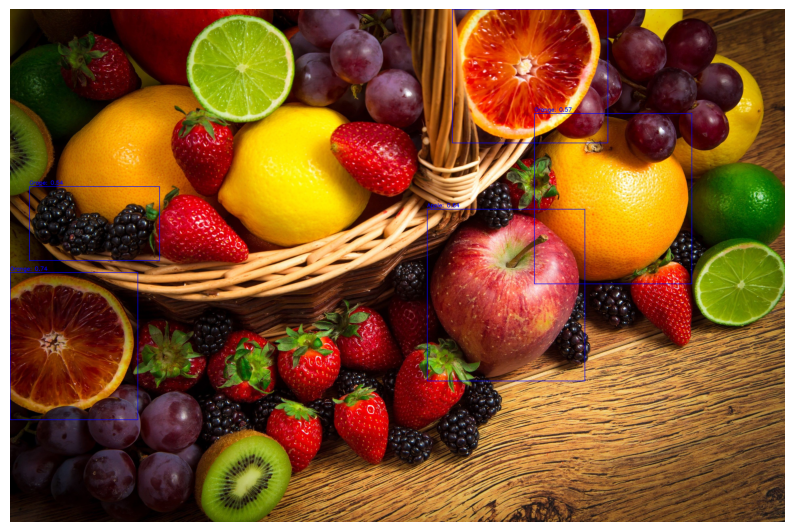

In [46]:
import cv2
import numpy as np
from google.colab import files

# Upload files
uploaded = files.upload()

for filename, content in uploaded.items():
    try:
        # Convert byte data to a numpy array
        nparr = np.frombuffer(content, np.uint8)

        # Decode the image
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # Check if the image has been correctly loaded
        if img is not None:
            print(f"Successfully opened {filename} using OpenCV")

            # If you need to use the image with another library that requires PIL Image format:
            from PIL import Image
            # Convert OpenCV image (numpy array) to PIL Image for consistency with other libraries
            img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Now you can use the image with your prediction model
            result = best_model.predict(img_pil, conf=0.51)
            print("Prediction result:", result)
        else:
            print(f"Failed to load image {filename}.")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

import matplotlib.pyplot as plt

# Assuming 'result' contains the prediction data and it's not a dictionary
try:
    # Access attributes directly from the result object
    prediction_data = result.prediction  # Adjust this if necessary based on the actual attribute names
    class_names = result.class_names     # Adjust if the actual structure is different

    # Create a copy of the image to draw on
    image_with_detections = img.copy()

    # Draw bounding boxes and labels on the image
    for (box, label, score) in zip(prediction_data.bboxes_xyxy, prediction_data.labels, prediction_data.confidence):
        start_point = (int(box[0]), int(box[1]))
        end_point = (int(box[2]), int(box[3]))
        color = (255, 0, 0)  # Blue color in BGR
        thickness = 2
        image_with_detections = cv2.rectangle(image_with_detections, start_point, end_point, color, thickness)
        cv2.putText(image_with_detections, f"{class_names[label]}: {score:.2f}", (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
except AttributeError as e:
    print(f"Error accessing prediction data: {e}")